<a href="https://colab.research.google.com/github/lymoelopez/filipino-fake-news-detection/blob/main/fakeNewsDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import itertools

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier, LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

from google.colab import files
import io
import matplotlib.pyplot as plt

import re
import string

from sklearn.metrics import precision_recall_fscore_support
import pickle


# Data Preparation




In [ ]:
# import from local files
uploaded = files.upload()

Saving full.csv to full.csv


In [ ]:
#Read dataset
df = pd.read_csv(io.BytesIO(uploaded['full.csv']))
# Dataset is now stored in a Pandas Dataframe

In [ ]:
#Get shape
df.shape

# output first 5 records
df.head()  

,label,article
0,0,"Ayon sa TheWrap.com, naghain ng kaso si Krupa,..."
1,0,Kilala rin ang singer sa pagkumpas ng kanyang ...
2,0,"BLANTYRE, Malawi (AP) -- Bumiyahe patungong Ma..."
3,0,"Kasama sa programa ang pananalangin, bulaklak ..."
4,0,Linisin ang Friendship Department dahil dadala...


In [ ]:
# Get dataFrame (df) labels
labels=df.label
labels.head() # 1 = fake, 0 = true

0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64

([<matplotlib.patches.Wedge at 0x7faeaa9470d0>,
 [Text(-1.2000000000000002, 1.469576158976824e-16, 'Fake'),
  Text(1.2000000000000002, -2.939152317953648e-16, 'True')],
 [Text(-0.7, 8.572527594031472e-17, '50.0%'),
  Text(0.7, -1.7145055188062944e-16, '50.0%')])

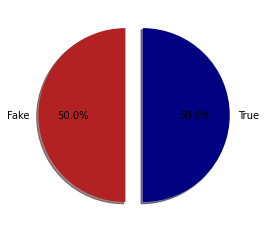

In [ ]:
# dataset distribution [pie chart]
fakeNewsCategory = pd.get_dummies(df.label)[1]  # 1 = fake, 0 = real
fakeNewsSize = fakeNewsCategory.sum()
realNewsSize = len(fakeNewsCategory)- fakeNewsSize

datasetSize = [fakeNewsSize, realNewsSize]

plt.pie(datasetSize,explode=[0.1,0.1],colors=['firebrick','navy'],startangle=90,shadow=True,labels=['Fake','True'],autopct='%1.1f%%')

# Data Augmentation (w/ Back Translation)

In [ ]:
# import from local files
uploadedBT = files.upload()

Saving backTranslated.csv to backTranslated.csv


In [ ]:
#Read dataset
dfBT = pd.read_csv(io.BytesIO(uploadedBT['backTranslated.csv']))
# Dataset is now stored in a Pandas Dataframe

In [ ]:
#Get shape
dfBT.shape

# output first 5 records
dfBT.head()  

,label,article
0,0,"Ayon sa TheWrap.com, si Krupa, 35, ay nagsampa..."
1,0,Kilala rin ang mang-aawit sa pagkumpas ng kany...
2,0,"BLANTYRE, Malawi (AP) -- Naglakbay si Madonna ..."
3,0,"Kasama sa programa ang panalangin, bulaklak a..."
4,0,Linisin ang Friendship Department dahil bibis...


In [ ]:
# Get dataFrame (df) labels
labelsBT=dfBT.label
labelsBT.head()           # 1 = fake, 0 = true

0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64

([<matplotlib.patches.Wedge at 0x7faeaa4333d0>,
 [Text(-1.2000000000000002, 1.469576158976824e-16, 'Fake'),
  Text(1.2000000000000002, -2.939152317953648e-16, 'True')],
 [Text(-0.7, 8.572527594031472e-17, '50.0%'),
  Text(0.7, -1.7145055188062944e-16, '50.0%')])

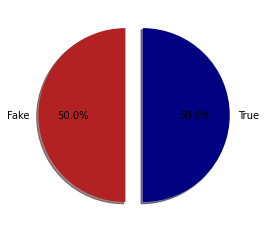

In [ ]:
# dataset distribution [pie chart]
fakeNewsCategoryBT = pd.get_dummies(dfBT.label)[1]  # 1 = fake, 0 = real
fakeNewsSizeBT = fakeNewsCategoryBT.sum()
realNewsSizeBT = len(fakeNewsCategoryBT)- fakeNewsSizeBT

datasetSizeBT = [fakeNewsSizeBT, realNewsSizeBT]

plt.pie(datasetSizeBT,explode=[0.1,0.1],colors=['firebrick','navy'],startangle=90,shadow=True,labels=['Fake','True'],autopct='%1.1f%%')

# Preprocessing

In [ ]:
# convert the text in lowercase, remove the extra space, special chr., ulr and links.
def removeCharactersAndLowercase(text):
    text = text.lower()                                                 # lower case
    text = re.sub('https?://\S+|www\.\S+', '', text)                    # remove url and links
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)                                       # Removing line or tab character (\n, \r, \t..)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('\s+',' ',text)                                       # remove extra space
    text = re.sub('(\\b[A-Za-z] \\b|\\b [A-Za-z]\\b)', '', text)        # remove single characters
    text = text.strip()                                                 # remove whitespaces at begin and end of the text

    return text

df_preprocess = df.copy()
dfBT_preprocess = dfBT.copy()

df_preprocess['article'] = df_preprocess['article'].apply(removeCharactersAndLowercase)
dfBT_preprocess['article'] = dfBT_preprocess['article'].apply(removeCharactersAndLowercase)

#### Byte Pair encoding

In [ ]:
!pip install bpemb -force-reinstall

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: orce-reinstall
     |████████████████████████████████| 1.3 MB 23.8 MB/s 


In [ ]:
from bpemb import BPEmb
bpemb_tl = BPEmb(lang="tl", dim=50)

downloading https://nlp.h-its.org/bpemb/tl/tl.wiki.bpe.vs10000.model


100%|██████████| 397105/397105 [00:00<00:00, 9965888.96B/s]


downloading https://nlp.h-its.org/bpemb/tl/tl.wiki.bpe.vs10000.d50.w2v.bin.tar.gz


100%|██████████| 1920249/1920249 [00:00<00:00, 31019573.04B/s]


In [ ]:
def findBPE (text):
  BPE = bpemb_tl.encode(text)
  text = " ".join(BPE)
  return text

df_BPE = df_preprocess.copy()
dfBT_BPE = dfBT_preprocess.copy()

df_BPE['article'] = df_BPE['article'].apply(findBPE)
dfBT_BPE['article'] = dfBT_BPE['article'].apply(findBPE)

df_BPE.head()


,label,article
0,0,▁ayon ▁sa ▁the w rap ▁com ▁nagha in ▁ng ▁kaso ...
1,0,▁kilala ▁rin ▁ang ▁sing er ▁sa ▁pag kum pas ▁n...
2,0,▁blan ty re ▁mala wi ▁ap ▁b umi ya he ▁patungo...
3,0,▁kasama ▁sa ▁programa ▁ang ▁panana langin ▁bul...
4,0,▁lin isin ▁ang ▁fri ends hip ▁department ▁dahi...


#### Stemming

In [ ]:
# change to default directory
%cd /content 
# remove TagalogStemmerPython, if another instance exist
!rm -r TagalogStemmerPython
!git clone https://github.com/lymoelopez/TagalogStemmerPython.git

# Change directory to cloned repo
%cd TagalogStemmerPython

/content
rm: cannot remove 'TagalogStemmerPython': No such file or directory
Cloning into 'TagalogStemmerPython'...
remote: Enumerating objects: 151, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 151 (delta 14), reused 0 (delta 0), pack-reused 121
Receiving objects: 100% (151/151), 804.87 KiB | 6.54 MiB/s, done.
Resolving deltas: 100% (76/76), done.
/content/TagalogStemmerPython


In [ ]:
from TglStemmer import stemmer

In [ ]:
def findStemmed(text):
  stemmed, root_only = stemmer("2", text, "3")
  text = " ".join(root_only)
  return text


df_stemmed = df_preprocess.copy()
dfBT_stemmed = dfBT_preprocess.copy()

df_stemmed['article'] = df_stemmed['article'].apply(findStemmed)
dfBT_stemmed['article'] = dfBT_stemmed['article'].apply(findStemmed)

df_stemmed.head()


,label,article
0,0,ayon sa hewrap com hain ng kaso si rupa noo hu...
1,0,kilala rin ang singed sa kumpas ng kanya kamay...
2,0,lantyre lawi ap biyahe tungon lawi si donna sa...
3,0,sama sa programa ang analang bulaklak at sindi...
4,0,lisin ang riendship department dahil dalaw ka ...


#Train-Test Split

In [ ]:
# 70 - 30 train test split
x_train1,x_test,y_train1,y_test=train_test_split(df['article'], labels, test_size=0.3, random_state=7)

In [ ]:
# use same random_state to split back translated dataset the same way
# we are only intrested in train split
# 70 - 30 train test split
x_trainBT,x_testBT,y_trainBT,y_testBT = train_test_split(dfBT['article'], labelsBT, test_size=0.3, random_state=7)

In [ ]:
x_train = x_train1.append(x_trainBT, ignore_index = True)
y_train = y_train1.append(y_trainBT, ignore_index = True)
print(x_train)

0       Ang Social Security Act of 2019, na nilikha ng...
1       Dismayado aniya ang mga pamilya ng mga biktima...
2       Hindi pa man nakakaupo bilang senador si ex-Ph...
3       Hindi na nagkapagpigil ang isa nating kababaya...
4       Ipinag-utos ni Pangulong Rodrigo Duterte sa Co...
                              ...                        
4483    ibinunyag ng pinuno ng tribo ang mga kalupitan...
4484    Good agricultural and livelihood news para sa ...
4485    "Ang akusado na si Juan Ponce Enrile, sa pamam...
4486    Sinabi ni Mendoza na binaril si Guliman matapo...
4487    Ito ang sinabi kahapon ni Bohol 2nd District R...
Name: article, Length: 4488, dtype: object


#### BPE

In [ ]:
x_train1_BPE,x_test_BPE,y_train1_BPE,y_test_BPE = train_test_split(df_BPE['article'], labels, test_size=0.3, random_state=7)
x_trainBT_BPE, x_testBT_BPE, y_trainBT_BPE, y_testBT_BPE = train_test_split(dfBT_BPE['article'], labelsBT, test_size=0.3, random_state=7)

x_train_BPE = x_train1_BPE.append(x_trainBT_BPE, ignore_index = True)
y_train_BPE = y_train1_BPE.append(y_trainBT_BPE, ignore_index = True)
print(x_train_BPE)


0       ▁ang ▁social ▁se cu rity ▁act ▁of ▁na ▁nilikha...
1       ▁dis ma yado ▁ani ya ▁ang ▁mga ▁pamilya ▁ng ▁m...
2       ▁hindi ▁pa ▁man ▁nakaka u po ▁bilang ▁senador ...
3       ▁hindi ▁na ▁nagka pag pigil ▁ang ▁isa ▁nating ...
4       ▁ipinag ▁utos ▁ni ▁pangulong ▁rodri go ▁du ter...
                              ...                        
4483    ▁ibin un yag ▁ng ▁pinuno ▁ng ▁tribo ▁ang ▁mga ...
4484    ▁good ▁agri cul tural ▁and ▁live li ho od ▁new...
4485    ▁ang ▁a kusa do ▁na ▁si ▁juan ▁pon ce ▁enri le...
4486    ▁sinabi ▁ni ▁mendoza ▁na ▁bina ril ▁si ▁gu lim...
4487    ▁ito ▁ang ▁sinabi ▁kaha pon ▁ni ▁bohol ▁distri...
Name: article, Length: 4488, dtype: object


#### Stemming

In [ ]:
x_train1_stemmed,x_test_stemmed,y_train1_stemmed,y_test_stemmed = train_test_split(df_stemmed['article'], labels, test_size=0.3, random_state=7)
x_trainBT_stemmed, x_testBT_stemmed, y_trainBT_stemmed, y_testBT_stemmed = train_test_split(dfBT_stemmed['article'], labelsBT, test_size=0.3, random_state=7)

x_train_stemmed = x_train1_stemmed.append(x_trainBT_stemmed, ignore_index = True)
y_train_stemmed = y_train1_stemmed.append(y_trainBT_stemmed, ignore_index = True)
print(x_train_stemmed)


0       ang social security act of na likha ng sena na...
1       dismayado aniya ang mga pamilya ng mga biktima...
2       hindi pa man kaupo bilang sena si e hilippine ...
3       hindi na pigil ang isa natin bayan at labas na...
4       pina utos ni ulo rodrigo duterte sa commission...
                              ...                        
4483    bunyag ng pinuno ng tribo ang mga lupit na gaw...
4484    good agricultural and livelihood news para sa ...
4485    ang akusado na si uan ponce enrile sa amagit n...
4486    sabi ni mendoza na baril si gulim tapos siya h...
4487    ito ang sabi hapon ni bohol district rep erico...
Name: article, Length: 4488, dtype: object


# Feature Extraction

In [ ]:
# Initialize a TfidfVectorizer
tfidf_vectorizer=TfidfVectorizer(max_df=0.7, min_df=5)

# Fit and transform train set, transform test set
tfidf_train=tfidf_vectorizer.fit_transform(x_train) 
tfidf_test=tfidf_vectorizer.transform(x_test)

#### BPE + TFIDF

In [ ]:
tfidf_vectorizer_BPE=TfidfVectorizer(max_df=0.7, min_df=5)

tfidf_train_BPE = tfidf_vectorizer_BPE.fit_transform(x_train_BPE) 
tfidf_test_BPE = tfidf_vectorizer_BPE.transform(x_test_BPE)


#### stemming + TFIDF

In [ ]:
tfidf_vectorizer_stemmed = TfidfVectorizer(max_df=0.7, min_df=5)

tfidf_train_stemmed = tfidf_vectorizer_stemmed.fit_transform(x_train_stemmed) 
tfidf_test_stemmed = tfidf_vectorizer_stemmed.transform(x_test_stemmed)


# Classification Algorithms

In [ ]:
def findPrecisionRecallF1score(confusionMatrix, fake_is_1):
  if fake_is_1:
    tn, fp, fn, tp = confusionMatrix.ravel()
  else:
    tp, fn, fp, tn = confusionMatrix.ravel()

# when fake news is 1 -> true positive   -> default
# when fake news is 0 -> true negative
  precision = tp/(tp + fp)
  recall = tp/(tp + fn)
  f1score = 2 * (recall * precision)/(recall + precision)
  
  print(f'Precision: {round(precision*100,2)}%')
  print(f'Recall: {round(recall*100,2)}%')
  print(f'F1-Score: {round(f1score*100,2)}%')


#### Passive Agressive Classifier

In [ ]:
def findPAC(tfidf_train, y_train, tfidf_test, y_test):
  pac=PassiveAggressiveClassifier(random_state=False)
  pac.fit(tfidf_train,y_train)

  y_pred=pac.predict(tfidf_test)
  score=accuracy_score(y_test,y_pred)
  print(f'Passive Agressive Accuracy: {round(score*100,2)}%')

  pac_cm = confusion_matrix(y_test,y_pred)

  print("Fake:")
  findPrecisionRecallF1score(pac_cm, 1)
  print("Real:")
  findPrecisionRecallF1score(pac_cm, 0)

  pac_cm_display = ConfusionMatrixDisplay(pac_cm).plot()
  return pac

###### BPE + TFIDF

Passive Agressive Accuracy: 94.18%
Fake:
Precision: 93.92%
Recall: 94.32%
F1-Score: 94.12%
Real:
Precision: 94.43%
Recall: 94.05%
F1-Score: 94.24%


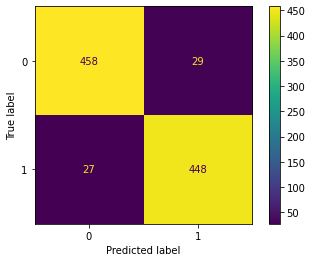

In [ ]:
pac_BPE = findPAC(tfidf_train_BPE, y_train_BPE, tfidf_test_BPE, y_test_BPE)

###### stemming + TFIDF

Passive Agressive Accuracy: 94.7%
Fake:
Precision: 94.35%
Recall: 94.95%
F1-Score: 94.65%
Real:
Precision: 95.04%
Recall: 94.46%
F1-Score: 94.75%


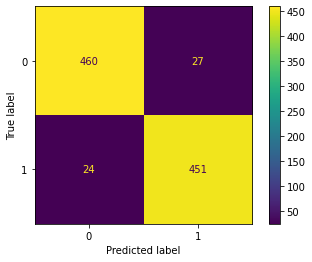

In [ ]:
pac_stemmed = findPAC(tfidf_train_stemmed, y_train_stemmed, tfidf_test_stemmed, y_test_stemmed)

#### Multinomial Naive Bayes

In [ ]:
def findMultNB(tfidf_train, y_train, tfidf_test, y_test):
  MultNB = MultinomialNB()
  MultNB.fit(tfidf_train,y_train)
  MultNB_pred=MultNB.predict(tfidf_test)

  score1=accuracy_score(y_test,MultNB_pred)
  print(f'Multinomial Naive Bayes Accuracy: {round(score1*100,2)}%')

  MultNB_cm = confusion_matrix(y_test,MultNB_pred)

  print("Fake:")
  findPrecisionRecallF1score(MultNB_cm, 1)
  print("Real:")
  findPrecisionRecallF1score(MultNB_cm, 0)

  MultNB_cm_display = ConfusionMatrixDisplay(MultNB_cm).plot()
  return MultNB

###### BPE + TFIDF

Multinomial Naive Bayes Accuracy: 87.53%
Fake:
Precision: 83.68%
Recall: 92.84%
F1-Score: 88.02%
Real:
Precision: 92.18%
Recall: 82.34%
F1-Score: 86.98%


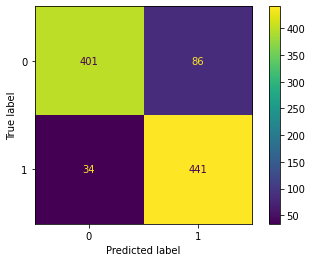

In [ ]:
MultNB_BPE = findMultNB(tfidf_train_BPE, y_train_BPE, tfidf_test_BPE, y_test_BPE)

###### stemming + TFIDF

Multinomial Naive Bayes Accuracy: 89.19%
Fake:
Precision: 85.07%
Recall: 94.74%
F1-Score: 89.64%
Real:
Precision: 94.23%
Recall: 83.78%
F1-Score: 88.7%


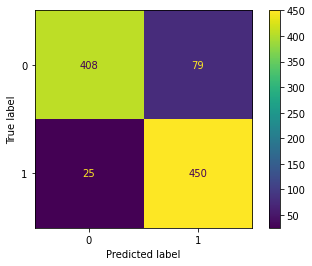

In [ ]:
MultNB_stemmed = findMultNB(tfidf_train_stemmed, y_train_stemmed, tfidf_test_stemmed, y_test_stemmed)

#### Random Forest

In [ ]:
def findRFC(tfidf_train, y_train, tfidf_test, y_test):
  rfc=RandomForestClassifier(random_state=False)
  rfc.fit(tfidf_train,y_train)
  rfc_pred = rfc.predict(tfidf_test)

  score2=accuracy_score(y_test,rfc_pred)
  print(f'Random Forest Accuracy: {round(score2*100,2)}%')

  rfc_cm = confusion_matrix(y_test,rfc_pred)

  print("Fake:")
  findPrecisionRecallF1score(rfc_cm, 1)
  print("Real:")
  findPrecisionRecallF1score(rfc_cm, 0)

  rfc_cm_display = ConfusionMatrixDisplay(rfc_cm).plot()
  return rfc

###### BPE + TFIDF

Random Forest Accuracy: 92.0%
Fake:
Precision: 91.12%
Recall: 92.84%
F1-Score: 91.97%
Real:
Precision: 92.89%
Recall: 91.17%
F1-Score: 92.02%


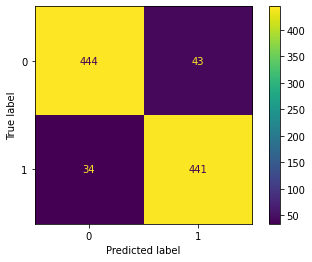

In [ ]:
rfc_BPE = findRFC(tfidf_train_BPE, y_train_BPE, tfidf_test_BPE, y_test_BPE)

###### stemming + TFIDF

Random Forest Accuracy: 91.16%
Fake:
Precision: 89.8%
Recall: 92.63%
F1-Score: 91.19%
Real:
Precision: 92.58%
Recall: 89.73%
F1-Score: 91.14%


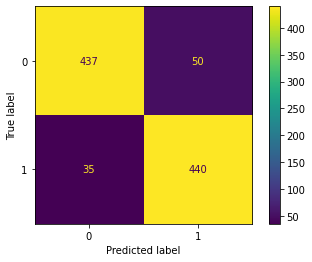

In [ ]:
rfc_stemmed = findRFC(tfidf_train_stemmed, y_train_stemmed, tfidf_test_stemmed, y_test_stemmed)

#### SVM

In [ ]:
def findSVC(tfidf_train, y_train, tfidf_test, y_test):
  svc = SVC()
  svc.fit(tfidf_train,y_train)
  svc_pred = svc.predict(tfidf_test)

  SVCscore=accuracy_score(y_test,svc_pred)
  print(f'SVC Accuracy: {round(SVCscore*100,2)}%')

  svc_cm = confusion_matrix(y_test,svc_pred)

  print("Fake:")
  findPrecisionRecallF1score(svc_cm, 1)
  print("Real:")
  findPrecisionRecallF1score(svc_cm, 0)

  svc_cm_display = ConfusionMatrixDisplay(svc_cm).plot()
  return svc

###### BPE + TFIDF

SVC Accuracy: 94.18%
Fake:
Precision: 95.44%
Recall: 92.63%
F1-Score: 94.02%
Real:
Precision: 93.01%
Recall: 95.69%
F1-Score: 94.33%


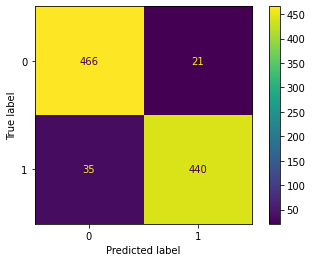

In [ ]:
svc_BPE = findSVC(tfidf_train_BPE, y_train_BPE, tfidf_test_BPE, y_test_BPE)

###### stemming + TFIDF

SVC Accuracy: 94.7%
Fake:
Precision: 95.3%
Recall: 93.89%
F1-Score: 94.59%
Real:
Precision: 94.13%
Recall: 95.48%
F1-Score: 94.8%


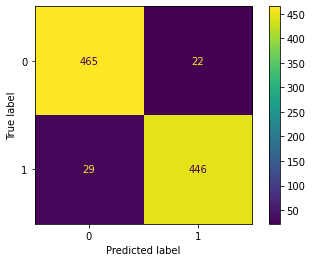

In [ ]:
svc_stemmed = findSVC(tfidf_train_stemmed, y_train_stemmed, tfidf_test_stemmed, y_test_stemmed)

#### Logistic Regression

In [ ]:
def findLogReg(tfidf_train, y_train, tfidf_test, y_test):
  LogReg = LogisticRegression()
  LogReg.fit(tfidf_train,y_train)
  LogReg_pred = LogReg.predict(tfidf_test)

  LogRegscore=accuracy_score(y_test,LogReg_pred)
  print(f'Logistic Regresion Accuracy: {round(LogRegscore*100,2)}%')

  LogReg_cm = confusion_matrix(y_test,LogReg_pred)

  print("Fake:")
  findPrecisionRecallF1score(LogReg_cm, 1)
  print("Real:")
  findPrecisionRecallF1score(LogReg_cm, 0)

  LogReg_cm_display = ConfusionMatrixDisplay(LogReg_cm).plot()
  return LogReg

###### BPE + TFIDF

Logistic Regresion Accuracy: 93.04%
Fake:
Precision: 94.16%
Recall: 91.58%
F1-Score: 92.85%
Real:
Precision: 92.0%
Recall: 94.46%
F1-Score: 93.21%


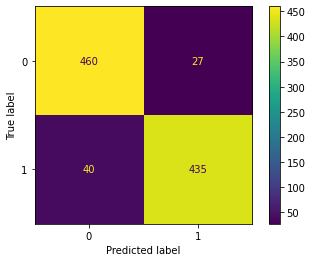

In [ ]:
LogReg_BPE = findLogReg(tfidf_train_BPE, y_train_BPE, tfidf_test_BPE, y_test_BPE)

###### stemming + TFIDF

Logistic Regresion Accuracy: 93.66%
Fake:
Precision: 94.42%
Recall: 92.63%
F1-Score: 93.52%
Real:
Precision: 92.94%
Recall: 94.66%
F1-Score: 93.79%


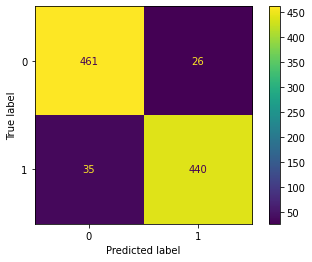

In [ ]:
LogReg_stemmed = findLogReg(tfidf_train_stemmed, y_train_stemmed, tfidf_test_stemmed, y_test_stemmed)

#### Stochastic Gradient Descent (SGD Classifier)

In [ ]:
def findSGD(tfidf_train, y_train, tfidf_test, y_test):
  sgd_clf = SGDClassifier(random_state=False)
  sgd_clf.fit(tfidf_train,y_train)
  sgd_pred = sgd_clf.predict(tfidf_test)

  SGDscore=accuracy_score(y_test,sgd_pred)
  print(f'SGD Accuracy: {round(SGDscore*100,2)}%')

  sgd_cm = confusion_matrix(y_test,sgd_pred)

  print("Fake:")
  findPrecisionRecallF1score(sgd_cm, 1)
  print("Real:")
  findPrecisionRecallF1score(sgd_cm, 0)

  sgd_cm_display = ConfusionMatrixDisplay(sgd_cm).plot()
  return sgd_clf

###### BPE + TFIDF

SGD Accuracy: 94.18%
Fake:
Precision: 94.67%
Recall: 93.47%
F1-Score: 94.07%
Real:
Precision: 93.71%
Recall: 94.87%
F1-Score: 94.29%


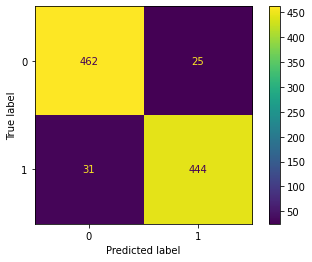

In [ ]:
sgd_clf_BPE = findSGD(tfidf_train_BPE, y_train_BPE, tfidf_test_BPE, y_test_BPE)

###### stemming + TFIDF

SGD Accuracy: 94.8%
Fake:
Precision: 95.12%
Recall: 94.32%
F1-Score: 94.71%
Real:
Precision: 94.5%
Recall: 95.28%
F1-Score: 94.89%


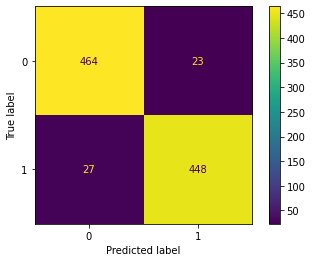

In [ ]:
sgd_clf_stemmed = findSGD(tfidf_train_stemmed, y_train_stemmed, tfidf_test_stemmed, y_test_stemmed)

#### Decision Tree Classifier

In [ ]:
def findDT(tfidf_train, y_train, tfidf_test, y_test):
  dt_clf = DecisionTreeClassifier(random_state=False)
  dt_clf.fit(tfidf_train,y_train)
  dt_pred = dt_clf.predict(tfidf_test)

  DTscore=accuracy_score(y_test,dt_pred)
  print(f'SGD Accuracy: {round(DTscore*100,2)}%')

  dt_cm = confusion_matrix(y_test,dt_pred)

  print("Fake:")
  findPrecisionRecallF1score(dt_cm, 1)
  print("Real:")
  findPrecisionRecallF1score(dt_cm, 0)

  dt_cm_display = ConfusionMatrixDisplay(dt_cm).plot()
  return dt_clf

###### BPE + TFIDF

SGD Accuracy: 87.01%
Fake:
Precision: 85.0%
Recall: 89.47%
F1-Score: 87.18%
Real:
Precision: 89.18%
Recall: 84.6%
F1-Score: 86.83%


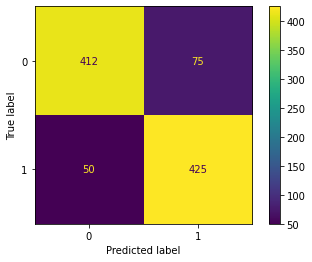

In [ ]:

dt_clf_BPE = findDT(tfidf_train_BPE, y_train_BPE, tfidf_test_BPE, y_test_BPE)

###### stemming + TFIDF

SGD Accuracy: 90.23%
Fake:
Precision: 90.27%
Recall: 89.89%
F1-Score: 90.08%
Real:
Precision: 90.18%
Recall: 90.55%
F1-Score: 90.37%


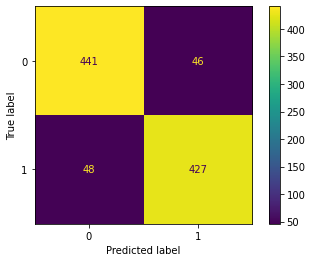

In [ ]:
dt_clf_stemmed = findDT(tfidf_train_stemmed, y_train_stemmed, tfidf_test_stemmed, y_test_stemmed)

#### XGBoost

In [ ]:
def findXGB(tfidf_train, y_train, tfidf_test, y_test):
  xgb_clf = xgb.XGBClassifier()
  xgb_clf.fit(tfidf_train,y_train)
  xgb_pred = xgb_clf.predict(tfidf_test)

  XGBscore=accuracy_score(y_test,xgb_pred)
  print(f'XGBoost Accuracy: {round(XGBscore*100,2)}%')

  xgb_cm = confusion_matrix(y_test,xgb_pred)

  print("Fake:")
  findPrecisionRecallF1score(xgb_cm, 1)
  print("Real:")
  findPrecisionRecallF1score(xgb_cm, 0)

  xgb_cm_display = ConfusionMatrixDisplay(xgb_cm).plot()

  return xgb_clf

###### BPE + TFIDF

XGBoost Accuracy: 92.31%
Fake:
Precision: 94.85%
Recall: 89.26%
F1-Score: 91.97%
Real:
Precision: 90.1%
Recall: 95.28%
F1-Score: 92.61%


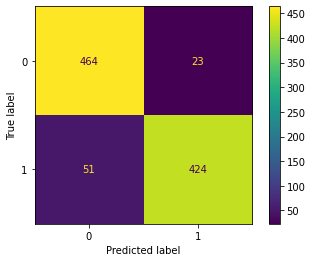

In [ ]:
xgb_BPE = findXGB(tfidf_train_BPE, y_train_BPE, tfidf_test_BPE, y_test_BPE)

###### stemming + TFIDF

XGBoost Accuracy: 93.76%
Fake:
Precision: 95.81%
Recall: 91.37%
F1-Score: 93.53%
Real:
Precision: 91.94%
Recall: 96.1%
F1-Score: 93.98%


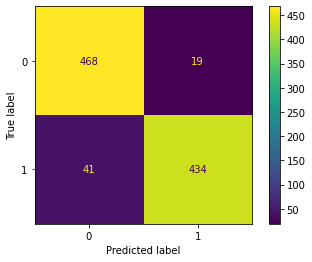

In [ ]:
xgb_stemmed = findXGB(tfidf_train_stemmed, y_train_stemmed, tfidf_test_stemmed, y_test_stemmed)

#### Extra Trees

In [ ]:
def findET(tfidf_train, y_train, tfidf_test, y_test):
  et = ExtraTreesClassifier(random_state=False)
  et.fit(tfidf_train,y_train)
  et_pred = et.predict(tfidf_test)

  ETscore=accuracy_score(y_test,et_pred)
  print(f'Extra Trees Accuracy: {round(ETscore*100,2)}%')

  et_cm = confusion_matrix(y_test,et_pred)

  print("Fake:")
  findPrecisionRecallF1score(et_cm, 1)
  print("Real:")
  findPrecisionRecallF1score(et_cm, 0)

  et_cm_display = ConfusionMatrixDisplay(et_cm).plot()
  return et

###### BPE + TFIDF

Extra Trees Accuracy: 90.75%
Fake:
Precision: 87.4%
Recall: 94.95%
F1-Score: 91.02%
Real:
Precision: 94.62%
Recall: 86.65%
F1-Score: 90.46%


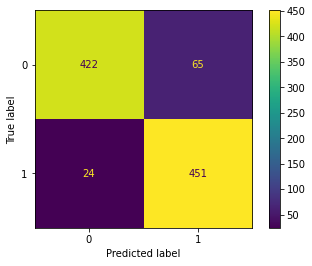

In [ ]:
et_BPE = findET(tfidf_train_BPE, y_train_BPE, tfidf_test_BPE, y_test_BPE)

###### stemming + TFIDF

Extra Trees Accuracy: 92.41%
Fake:
Precision: 89.88%
Recall: 95.37%
F1-Score: 92.54%
Real:
Precision: 95.2%
Recall: 89.53%
F1-Score: 92.28%


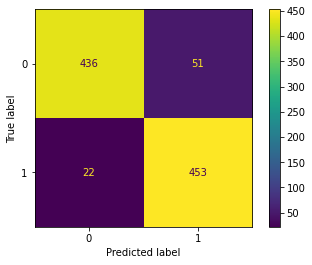

In [ ]:
et_stemmed = findET(tfidf_train_stemmed, y_train_stemmed, tfidf_test_stemmed, y_test_stemmed)

#### AdaBoost

In [ ]:
def findABC(tfidf_train, y_train, tfidf_test, y_test):
  abc = AdaBoostClassifier(random_state=False)
  abc.fit(tfidf_train,y_train)
  abc_pred = abc.predict(tfidf_test)

  ABCscore=accuracy_score(y_test,abc_pred)
  print(f'adaBoost Accuracy: {round(ABCscore*100,2)}%')

  abc_cm = confusion_matrix(y_test,abc_pred)

  print("Fake:")
  findPrecisionRecallF1score(abc_cm, 1)
  print("Real:")
  findPrecisionRecallF1score(abc_cm, 0)

  abc_cm_display = ConfusionMatrixDisplay(abc_cm).plot()
  return abc

###### BPE + TFIDF

adaBoost Accuracy: 91.89%
Fake:
Precision: 93.06%
Recall: 90.32%
F1-Score: 91.67%
Real:
Precision: 90.82%
Recall: 93.43%
F1-Score: 92.11%


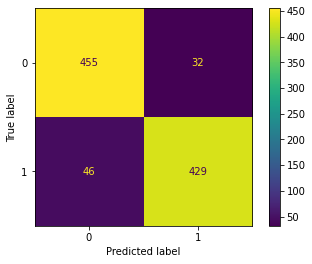

In [ ]:
abc_BPE = findABC(tfidf_train_BPE, y_train_BPE, tfidf_test_BPE, y_test_BPE)

###### stemming + TFIDF

adaBoost Accuracy: 92.2%
Fake:
Precision: 93.29%
Recall: 90.74%
F1-Score: 92.0%
Real:
Precision: 91.2%
Recall: 93.63%
F1-Score: 92.4%


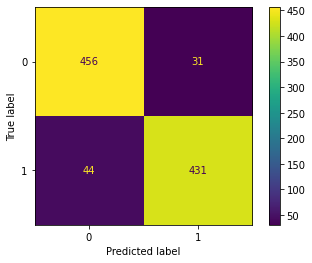

In [ ]:
abc_stemmed = findABC(tfidf_train_stemmed, y_train_stemmed, tfidf_test_stemmed, y_test_stemmed)

# Voting Classifier

In [ ]:
def findVoting(pac, MultNB,rfc, svc, LogReg, sgd_clf, dt_clf, xgb, et, abc, tfidf_train,y_train, tfidf_test):
  estimatorList = [('pac',pac),('MultNB',MultNB),('rfc',rfc),('svc',svc),('LogReg',LogReg),
                  ('sgd_clf',sgd_clf),('dt_clf',dt_clf),('xgb',xgb),('et',et),('abc',abc)]


  Ensemb = VotingClassifier(estimators = estimatorList, voting = 'hard')
  Ensemb.fit(tfidf_train,y_train)
  Ensemb_pred=Ensemb.predict(tfidf_test)

  score4=accuracy_score(y_test,Ensemb_pred)
  print(f'Ensemble Learning Accuracy: {round(score4*100,2)}%')

  Ensemb_cm = confusion_matrix(y_test,Ensemb_pred)

  print("Fake:")
  findPrecisionRecallF1score(Ensemb_cm, 1)
  print("Real:")
  findPrecisionRecallF1score(Ensemb_cm, 0)

  Encemb_cm_display = ConfusionMatrixDisplay(Ensemb_cm).plot()

  return Ensemb

In [ ]:
def findVoting_noSVM(pac, MultNB,rfc, LogReg, sgd_clf, dt_clf, xgb, et, abc, tfidf_train,y_train, tfidf_test):
  estimatorList = [('pac',pac),('MultNB',MultNB),('rfc',rfc),('LogReg',LogReg),
                  ('sgd_clf',sgd_clf),('dt_clf',dt_clf),('xgb',xgb),('et',et),('abc',abc)]


  Ensemb = VotingClassifier(estimators = estimatorList, voting = 'hard')
  Ensemb.fit(tfidf_train,y_train)
  Ensemb_pred=Ensemb.predict(tfidf_test)

  score4=accuracy_score(y_test,Ensemb_pred)
  print(f'Ensemble Learning Accuracy: {round(score4*100,2)}%')

  Ensemb_cm = confusion_matrix(y_test,Ensemb_pred)

  print("Fake:")
  findPrecisionRecallF1score(Ensemb_cm, 1)
  print("Real:")
  findPrecisionRecallF1score(Ensemb_cm, 0)

  Encemb_cm_display = ConfusionMatrixDisplay(Ensemb_cm).plot()

  return Ensemb

###### BPE + TFIDF

Ensemble Learning Accuracy: 94.91%
Fake:
Precision: 95.91%
Recall: 93.68%
F1-Score: 94.78%
Real:
Precision: 93.98%
Recall: 96.1%
F1-Score: 95.03%


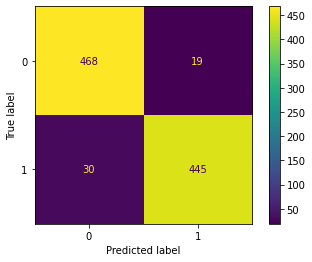

In [ ]:
Ensemb_BPE = findVoting(pac_BPE, MultNB_BPE, rfc_BPE, svc_BPE, LogReg_BPE, sgd_clf_BPE, dt_clf_BPE, xgb_BPE, et_BPE, abc_BPE, tfidf_train_BPE, y_train_BPE, tfidf_test_BPE)

Ensemble Learning Accuracy: 94.8%
Fake:
Precision: 95.12%
Recall: 94.32%
F1-Score: 94.71%
Real:
Precision: 94.5%
Recall: 95.28%
F1-Score: 94.89%


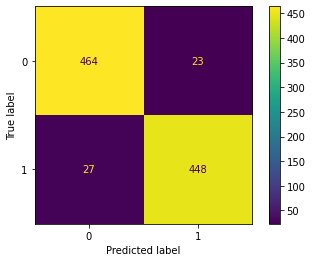

In [ ]:
# no SVM
Ensemb_BPE = findVoting_noSVM(pac_BPE, MultNB_BPE, rfc_BPE, LogReg_BPE, sgd_clf_BPE, dt_clf_BPE, xgb_BPE, et_BPE, abc_BPE, tfidf_train_BPE, y_train_BPE, tfidf_test_BPE)

#### stemming + TFIDF

Ensemble Learning Accuracy: 95.11%
Fake:
Precision: 95.92%
Recall: 94.11%
F1-Score: 95.01%
Real:
Precision: 94.35%
Recall: 96.1%
F1-Score: 95.22%


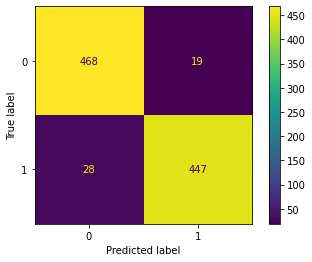

In [ ]:
Ensemb_stemmed = findVoting(pac_stemmed, MultNB_stemmed, rfc_stemmed, svc_stemmed, LogReg_stemmed, sgd_clf_stemmed, dt_clf_stemmed, xgb_stemmed, et_stemmed, abc_stemmed, tfidf_train_stemmed, y_train_stemmed, tfidf_test_stemmed)

Ensemble Learning Accuracy: 95.11%
Fake:
Precision: 95.34%
Recall: 94.74%
F1-Score: 95.04%
Real:
Precision: 94.9%
Recall: 95.48%
F1-Score: 95.19%


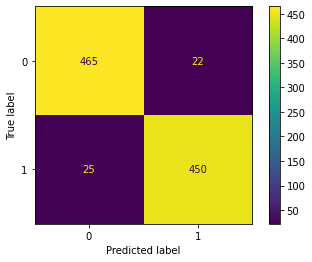

In [ ]:
# no SVM
Ensemb_stemmed = findVoting_noSVM(pac_stemmed, MultNB_stemmed, rfc_stemmed, LogReg_stemmed, sgd_clf_stemmed, dt_clf_stemmed, xgb_stemmed, et_stemmed, abc_stemmed, tfidf_train_stemmed, y_train_stemmed, tfidf_test_stemmed)

In [ ]:
%cd /content

filename = 'Ensemb_BPE.sav'
pickle.dump(Ensemb_BPE, open(filename, 'wb'))

filename = 'Ensemb_stemmed.sav'
pickle.dump(Ensemb_stemmed, open(filename, 'wb'))


/content


#### Sample Real News
https://news.abs-cbn.com/entertainment/12/11/22/john-denver-trending-kauna-unahang-pinoy-film-na-naipalabas-sa-mga-sinehan-sa-sokor

In [ ]:
inputReal = "SOUTH KOREA - Sa kauna-unahang pagkakataon, napanood ang pelikulang Pinoy sa mga sinehan sa South Korea gaya ng CGV, Lotte Cinema at Megabox. Gumawa ng kasaysayan ang pelikulang 'John Denver Trending' bilang ang pinakaunang Pinoy film na ipinalabas sa mga wide screen cinemas sa South Korea. “John Denver Trending is an award-winning and critically-acclaimed film from the Philippines. It won best picture at the Philippine Cinemalaya Independent Film Festival. This film was screened at the 24th Busan International Film Festival...you are all part of the history because it is the first Philippine film to be shown commercially in wide release in Korea,” pahayag ni Ambasador Ma. Theresa B. Dizon-De Vega. Isinulat at idinirek ni Arden Rod Condez ang pelikula na pinagbidahan nina Jansen Magpusao at Meryll Soriano.  “It is a story about issues that many young people in different countries, not just in the Philippines, but also in Korea, face every day. Themes of alienation, the use and influence of social media and online bullying are all exhibited and seen in this beautiful film. It has many lessons for everyone; for parents, for young people, for teachers and for the whole of the society,” dagdag ni Amb. Dizon-De Vega.  Sa mga katulad ni Silvia Kim na isang social media influencer, relatable and pelikula lalo na sa mga negatibo at batikos mula sa mga komento.   “This is so realistic. And it was like a documentary...more relatable,” ani Sylvia. Natuwa ang mga manonood maging ang mga Korean.   “It was an honor for me to watch this movie. For me, frankly speaking, I visited the Philippines several times, so when I watched the movie, the sceneries the views of the movie, was [were] familiar to me. And it was [like], Oh I saw the schools, I saw the roads. It was so interesting and was amazing, especially the topic… it was so touching, it was heavy. It was good and educational,” sabi ni Hoseung Jung, isang aktor sa South Korea. Hindi man ito Korean film, pinanood pa rin ito ng mga Korean at maging ng mga Pinoy dahil sa mensaheng dala ng pelikula na angkop sa makabagong panahon."

#### Sample Fake News
https://www.factrakers.org/post/robredo-didn-t-concede-in-may-10-speech

In [ ]:
inputFakeGossip = "#NationalNews Lamang na ng mahigit 16M ang BBM/SARA tandem sa kalabang Leni/Kiko sa pinakahuling update ng partial unofficial counts ng COMELEC. Aabot sa halos 30M mahigit ang botong nakuna ni presidential candidate Bong bong Marcos habang nasa mahigit 14M lamang ang nakuhang boto ni presidential candidate Leni Robredo. Gayun din si vice presidential candidate Sara Duterte na nakakuha ng mahigit 30M na boto habang nasa mahigit 8M na boto naman ang nakuha ni vice presidential candidate Kiko Pangilinan. Kanina ang nag-concede na si Leni Robredo at tinanggap na nito ang kaniyang pagkatalo kay BBM ngayong #halalan2022, habang nagpasalamat naman kapwa si BBM at Sara sa kanilang mga taga suporta. | #palawanstar"



#### BPE + TFIDF

In [ ]:
def BPE_TFIDF_Prediction(inputText):  
  inputText_cleaned = removeCharactersAndLowercase(inputText)
  inputText_BPE = findBPE(inputText_cleaned)
  inputText_BPE = [inputText_BPE]
  inputText_tfidf_BPE = tfidf_vectorizer_BPE.transform(inputText_BPE)
  prediction_tfidf_BPE = Ensemb_BPE.predict(inputText_tfidf_BPE)
  if prediction_tfidf_BPE[0] == 0:
    prediction = "Real"
  else:
    prediction = "Fake"
  print(prediction)

In [ ]:
BPE_TFIDF_Prediction(inputReal)
BPE_TFIDF_Prediction(inputFakeGossip)

Real
Fake


#### stemming + TFIDF

In [ ]:
def stemming_TFIDF_Prediction(inputText):  
  inputText_cleaned = removeCharactersAndLowercase(inputText)
  inputText_stemmed = findStemmed(inputText_cleaned)
  inputText_stemmed = [inputText_stemmed]
  inputText_tfidf_stemmed = tfidf_vectorizer_stemmed.transform(inputText_stemmed)
  prediction_tfidf_stemmed = Ensemb_stemmed.predict(inputText_tfidf_stemmed)
  if prediction_tfidf_stemmed[0] == 0:
    prediction = "Real"
  else:
    prediction = "Fake"
  print(prediction)

In [ ]:
stemming_TFIDF_Prediction(inputReal)
stemming_TFIDF_Prediction(inputFakeGossip)

Real
Fake


# References

[1] https://data-flair.training/blogs/advanced-python-project-detecting-fake-news/

[2] https://github.com/nabi-hassan/Fake-news-Detection-using-Ensemble-Learning-/blob/master/newnote.ipynb

[3] https://towardsdatascience.com/fake-news-detection-with-machine-learning-using-python-3347d9899ad1

[4] https://jovian.ai/piero-paialunga/notebook

[5] https://youtu.be/5X27excCyXk

[6] https://medium.com/@yashj302/text-cleaning-using-regex-python-f1dded1ac5bd

[7] https://stackoverflow.com/questions/32705962/removing-any-single-letter-on-a-string-in-python?answertab=scoredesc#tab-top